In [1]:
import os,sys,time,random,math,time
import tarfile, zipfile

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.linear_model import LinearRegression,Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor
from sklearn.svm import SVR
from sklearn import decomposition, datasets, ensemble
from sklearn.cluster import KMeans,MeanShift

from sklearn.base import clone as skclone
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import make_scorer,precision_score, recall_score, f1_score, average_precision_score, accuracy_score, mean_absolute_error

from sklearn.preprocessing import MinMaxScaler
import itertools

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers.advanced_activations import PReLU

import matplotlib.pyplot as plt
from IPython.display import display, Image

import xgboost as xgb

use_xgb=True #disable for speed

from subprocess import check_output
datadir="./input/"
print(check_output(["ls", datadir]).decode("utf8"))

%matplotlib inline  


Using TensorFlow backend.


test.csv
test.csv.zip
train.csv
train.csv.zip



In [2]:
def loadData(datadir,filename):
    # Load the wholesale customers dataset
    #data = pd.read_csv(filename)
    data = ''
    print ("loading: "+datadir+filename)
    try:
        if zipfile.is_zipfile(datadir+filename):
            z = zipfile.ZipFile(datadir+filename)
            filename = z.open(filename[:-4])
        else:
            filename=datadir+filename
        data = pd.read_csv(filename, parse_dates=True)  
        print ("Dataset has {} samples with {} features each.".format(*data.shape))
    except Exception as e:
        print ("Dataset could not be loaded. Is the dataset missing?")
        print(e)
    return data

def writeData(data,filename):
    # Load the wholesale customers dataset
    try:
        data.to_csv(filename, index=False)
    except Exception as e:
        print ("Dataset could not be written.")
        print(e)
    verify=[]
    try:
        with open(filename, 'r') as f:
            for line in f:
                verify.append(line)
        f.closed
        return verify[:5]
    except IOError:
        sys.std
        

In [3]:

def LabelEncoder(data):
    # lifted in parts from:
    #https://www.kaggle.com/mmueller/allstate-claims-severity/yet-another-xgb-starter/code
    features = data.columns
    cats = [feat for feat in features if 'cat' in feat]
    for feat in cats:
        data[feat] = pd.factorize(data[feat], sort=True)[0]
    return data

In [4]:
def kmeansPlusmeanshift(data):
    start_time = time.time()
    startingClusterSize=int(len(data)*.075)
    print "kmeans.... for {} clusters".format(startingClusterSize)
    k_means =KMeans(n_clusters=startingClusterSize,n_jobs=10)
    k_means.fit(data.sample(frac=0.35).values)
    clusters=k_means.cluster_centers_
    print("kmeans round 1 time:{}s".format(round((time.time()-start_time), 3) ))
    print clusters[:15]
    
    start_time = time.time()
    #use the cluster centers of the guessed clusters to get an estimate of actual numbers of clusters. doing this for speed increase!
    print "\nmeanshift..."
    meanshift=MeanShift(n_jobs=10)
    meanshift.fit(clusters)
    newcenters=meanshift.cluster_centers_
    print("meanshift time:{}s".format(round((time.time()-start_time), 3) ))
    print newcenters[:15], "\nnum of clusters from meanshift:",len(newcenters)
    
    start_time = time.time()
    # use the new clusters number to predict each locations cluster
    print "\nredo kmeans with new cluster number from meanshift +1 to account for sampling..."
    k_means =KMeans(n_clusters=len(newcenters)+1,n_jobs=10)
    final_clusters=k_means.fit_predict(data.values)
    print("kmeans round 2 time:{}s".format(round((time.time()-start_time), 3) ))
    return final_clusters

In [5]:
def kmeansPlusmeanshift(data):  # used the one above to get the # of clusters, using this for speed
    start_time = time.time()
    # use the new clusters number to predict each locations cluster
    print "\nredo kmeans with new cluster number from meanshift +1 to account for sampling..."
    k_means =KMeans(n_clusters=80,n_jobs=12)
    final_clusters=k_means.fit_predict(data.values)
    print("kmeans round 2 time:{}s".format(round((time.time()-start_time), 3) ))
    return final_clusters

In [6]:
def grid_search_wrapper(x,y,regr,param,regr_name='BLANK'):
    start_time = time.time()
    print("In:{}".format(regr))
    filename= 'grid_{}.pkl'.format(regr_name)
    if os.path.isfile(filename):
        print filename," exists, importing "
        return joblib.load(filename) 
    else:
        print("{} not present, running a gridsearch".format(filename))
        #search the param_grid for best params based on the f1 score
        grid_search = GridSearchCV(regr,
                                   param_grid= param,
                                   n_jobs= -1,
                                   scoring=make_scorer(mean_absolute_error,greater_is_better=False)) 
        grid_search.fit(x,y)
        #reach into the grid search and pull out the best parameters, and set those on the clf
        params={}
        for p in grid_search.best_params_:
            params[p]=grid_search.best_params_[p]
        regr.set_params(**params)
        print("run time:{}s".format(round((time.time()-start_time), 3) ))   
        joblib.dump(regr,filename) 
    return regr

In [7]:
data = loadData(datadir,'train.csv.zip')
display(data.info())
display(data.head(5))

test_data= loadData(datadir,'test.csv.zip') 
display(test_data.info())
display(test_data.head(5))

loading: ./input/train.csv.zip
Dataset has 188318 samples with 132 features each.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB


None

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


loading: ./input/test.csv.zip
Dataset has 125546 samples with 131 features each.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125546 entries, 0 to 125545
Columns: 131 entries, id to cont14
dtypes: float64(14), int64(1), object(116)
memory usage: 125.5+ MB


None

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,4,A,B,A,A,A,A,A,A,B,...,0.281143,0.466591,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562
1,6,A,B,A,B,A,A,A,A,B,...,0.836443,0.482425,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045
2,9,A,B,A,B,B,A,B,A,B,...,0.718531,0.212308,0.325779,0.29758,0.34365,0.30529,0.245410,0.241676,0.258586,0.297232
3,12,A,A,A,A,B,A,A,A,A,...,0.397069,0.369930,0.342355,0.40028,0.33237,0.31480,0.348867,0.341872,0.592264,0.555955
4,15,B,A,A,A,A,B,A,A,A,...,0.302678,0.398862,0.391833,0.23688,0.43731,0.50556,0.359572,0.352251,0.301535,0.825823


###  Pre Proccessing

In [8]:
# combine the two frames so we can encode the labels!
test_data['loss']=0

lengthofData=len(data)
lengthoftest_data=len(test_data)

print("data:",lengthofData)
print("test:",lengthoftest_data)

combineddata=pd.concat([data,test_data])
lengthofcombined=len(combineddata)
print("combined:",lengthofcombined)

('data:', 188318)
('test:', 125546)
('combined:', 313864)


In [9]:
# the categorical data that we need in a number format
combineddata=LabelEncoder(combineddata)
print("label encoded")

label encoded


In [10]:
#predict the cluster for each row
filename='clusters.npy'
if os.path.isfile(filename):
    print("File found, using it")
    combineddata['clusters']=joblib.load(filename)
else:
    print("no files, running clusters...")
    combineddata['clusters']=kmeansPlusmeanshift(combineddata.drop(['id','loss'],1))
    joblib.dump(combineddata['clusters'],filename)
print("clusters loaded and attached")
print(combineddata.head(3)['clusters'])

File found, using it
clusters loaded and attached
0    27
1    13
2     0
Name: clusters, dtype: int32


In [11]:
hold_columns=combineddata[['loss','id']] #don't want to mess with these

combineddata.drop(['loss','id'],1,inplace=True) 
columns=combineddata.columns #need these to recreate the DF

#scale the columns we see
scaler= MinMaxScaler()   
values = scaler.fit_transform(combineddata.values)
combineddata= pd.DataFrame(values, columns=columns)

#put these back on for the moment!
combineddata['loss']=hold_columns['loss'].tolist()
combineddata['id']=hold_columns['id'].tolist()
del hold_columns
del values
del scaler
print "Data scaled"

Data scaled


In [12]:
# taken from Ali's script (https://www.kaggle.com/aliajouz/allstate-claims-severity/singel-model-lb-1117)
combineddata["cont1"] = np.sqrt(combineddata["cont1"])
combineddata["cont4"] = np.sqrt(combineddata["cont4"])
combineddata["cont5"] = np.sqrt(combineddata["cont5"])
combineddata["cont8"] = np.sqrt(combineddata["cont8"])
combineddata["cont10"] = np.sqrt(combineddata["cont10"])
combineddata["cont11"] = np.sqrt(combineddata["cont11"])
combineddata["cont12"] = np.sqrt(combineddata["cont12"])

combineddata["cont6"] = np.log(combineddata["cont6"] + 0000.1)
combineddata["cont7"] = np.log(combineddata["cont7"] + 0000.1)
combineddata["cont9"] = np.log(combineddata["cont9"] + 0000.1)
combineddata["cont13"] = np.log(combineddata["cont13"] + 0000.1)
combineddata["cont14"] = (np.maximum(combineddata["cont14"] - 0.179722, 0) / 0.665122) ** 0.25


In [13]:
display(data.info())
display(data.head(3))
# time to split the data back apart!
data=combineddata.iloc[:lengthofData].copy()
test_data=combineddata.iloc[lengthofData:].copy()
x_test_data=test_data.drop(['loss','id'],1) .values# didn't have the loss column before, make it go away! don't need ID!


# we don't want the ID columns in X
x=data.drop(['id','loss'],1).values
# loss is our label
#y=data['loss'].values
y = np.log(data['loss']).ravel()

print("Pre-Processing done")
display(data.info())
display(data.head(3))
print("data:",len(x))
print("labels:",len(y))
print("test:",len(x_test_data))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB


None

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09


Pre-Processing done
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 133 entries, cat1 to id
dtypes: float64(132), int64(1)
memory usage: 191.1 MB


None

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont8,cont9,cont10,cont11,cont12,cont13,cont14,clusters,loss,id
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.296826,-0.255633,0.916140,0.744792,0.761787,-0.070392,0.984628,0.341772,2213.18,1
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.698552,-0.792214,0.664384,0.560798,0.585682,-0.330645,0.343682,0.164557,1283.60,2
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.220662,-1.016372,0.571049,0.599347,0.591963,-1.211326,1.018094,0.000000,3005.09,5


('data:', 188318)
('labels:', 188318)
('test:', 125546)


In [14]:
#del data,test_data
#del combineddata
#del scaler
#del x_test

### pick our sklearn regressors, and do some param optimizations

In [15]:
regressor_w_grid=[] # a list of regressions to use
#regrList.append([LinearRegression()])
regressor_w_grid.append([ExtraTreesRegressor(n_jobs = -1),
                         dict(n_estimators=[3,5,7,10,25,50,200,500],
                         max_features=['auto','sqrt','log2'])])
regressor_w_grid.append([Ridge(),
                         dict(alpha=[.05,.5,1,2,4,40,140,400])])
regressor_w_grid.append([RandomForestRegressor(#criterion = 'mae',
                                      n_jobs =-1, 
                                      random_state=42),
                        dict(n_estimators=[2,5,7,10,25,50,200,500],
                             max_features=['auto','sqrt','log2'])])
#regressor_w_grid.append([KNeighborsRegressor(n_jobs = -1),
                       # dict(n_neighbors=[2,5,7,15],
                             #leaf_size =[3,10,15,25,30,50,100])])
#regrList.append([SVR(), dict()]) # oh my so slow! and bad initial scores



regrList=np.array(regressor_w_grid).T[0]
paramater_grid=np.array(regressor_w_grid).T[1]
print regrList
print paramater_grid

print("number of scikitlearn regressors to use:",len(regrList))

[ ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
 Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)
 KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
          weights='uniform')]
[ {'max_features': ['auto', 'sqrt', 'log2'], 'n_estimators': [5, 7,

In [16]:
#  train/validation split
X_train, X_validation, y_train, y_validation = train_test_split( x,
                                                                y,
                                                               test_size=0.20,
                                                                random_state=42)
display("sample train data size:{}".format(len(y_train)))

'sample train data size:150654'

In [17]:
start_time0 = time.time()
for i in range(len(regrList)):
    regrList[i]=grid_search_wrapper(X_train,y_train,regrList[i],paramater_grid[i],regr_name="regr{}".format(i))
    
print("Full GridSearch run time:{}s".format(round((time.time()-start_time0), 3) ))   



In:ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
grid_regr0.pkl  exists, importing 
In:Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
grid_regr1.pkl  exists, importing 
In:RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)
grid_regr2.pkl  exists, importing 
In:KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_nei

In [18]:
# XGB!
dtrain = xgb.DMatrix(X_train, label=y_train)

#my first tries:
xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.7,
    'silent': 1,
    'subsample': 0.7,
    'learning_rate': 0.075,
    'objective': 'reg:linear',
    'max_depth': 6,
    'num_parallel_tree': 1,
    'min_child_weight': 1,
    'eval_metric': 'mae',
}
#params from:
#https://www.kaggle.com/mnabaee/allstate-claims-severity/labelencoding-and-xgb-cv/discussion
xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.3085,
    'silent': 1,
    'subsample': 0.7,
    'learning_rate': 0.01,
    'objective': 'reg:linear',
    'max_depth': 10,
    'num_parallel_tree': 1,
    'min_child_weight': 4.2922,
    'eval_metric': 'mae',
    'eta':0.001,
    'gamma': 0.5290,
    'subsample':0.9930,
    'max_delta_step':0,
    'booster':'gbtree',
    'nrounds': 1001
}

start_time = time.time()
res = xgb.cv(xgb_params, dtrain, num_boost_round=2001, nfold=4, seed=42, stratified=False,
             early_stopping_rounds=50, verbose_eval=100, show_stdv=True, maximize=False)
print("CV time:{}s".format(round((time.time()-start_time), 3) ))

best_nrounds = res.shape[0] - 1
cv_mean = res.iloc[-1, 0]
cv_std = res.iloc[-1, 1]
print('CV-Mean: {0}+{1}'.format(cv_mean, cv_std))


[0]	train-mae:7.11322+0.00189574	test-mae:7.11323+0.00572075
[100]	train-mae:2.60582+0.00077029	test-mae:2.60588+0.00448456
[200]	train-mae:0.983877+0.000576019	test-mae:0.986147+0.00415985
[300]	train-mae:0.520782+0.000332036	test-mae:0.532829+0.00320902
[400]	train-mae:0.423562+0.000421764	test-mae:0.445216+0.00240648
[500]	train-mae:0.398615+0.000624741	test-mae:0.427596+0.00207862
[600]	train-mae:0.387494+0.000799236	test-mae:0.422581+0.00189632
[700]	train-mae:0.37991+0.000825092	test-mae:0.420351+0.00191068
[800]	train-mae:0.373903+0.000906556	test-mae:0.419096+0.0019114
[900]	train-mae:0.368832+0.00101925	test-mae:0.418284+0.00189456
[1000]	train-mae:0.36431+0.00095956	test-mae:0.417721+0.00189106
[1100]	train-mae:0.360257+0.000917152	test-mae:0.417245+0.00191358
[1200]	train-mae:0.356707+0.00102486	test-mae:0.416892+0.00188702
[1300]	train-mae:0.353533+0.00103758	test-mae:0.416634+0.00187893
[1400]	train-mae:0.350433+0.00108076	test-mae:0.416401+0.00185242
[1500]	train-mae:0.34

In [19]:
del X_train, X_validation, y_train, y_validation

### Stacking Layer 1, train and predict for layer 2

Split the data into k-folds(divisions). train the regressors on each combination of k-1 folds, and then predict on the held-out fold. Preserve the prediction of each regressor for the next layer.

In [20]:
#prepare the fold divisions

data_size=x.shape[0]
print "size of train data:",data_size
folds=[]
num_folds=5
fold_start=0
for k in range(num_folds-1):
    fold_end=((data_size/num_folds)*(k+1))
    folds.append((fold_start,fold_end))
    fold_start=fold_end
folds.append((fold_start,data_size))
print "folds at:",folds
print "fold size:", (data_size/num_folds)
print "train size:",(data_size/num_folds)*(num_folds-1)

count=0
for i in folds:
    count+=i[1]-i[0]
print count

size of train data: 188318
folds at: [(0, 37663), (37663, 75326), (75326, 112989), (112989, 150652), (150652, 188318)]
fold size: 37663
train size: 150652
188318


In [21]:
x_layer2=[]
start_time0 = time.time()
MAE_tracking=[]

if os.path.isfile('x_layer2.npy'):
    print 'x_layer2.npy'," exists, importing "
    #reuse the run
    x_layer2=joblib.load('x_layer2.npy') 
    MAE_tracking=joblib.load('MAE_tracking.npy')
else:
    for fold_start,fold_end in folds:
        print("---Fold:{} to {} of: {}".format(fold_start,fold_end,data_size))
        start_time1 = time.time()
        fold_result=[]

        X_test = x[fold_start:fold_end].copy()
        y_test = y[fold_start:fold_end].copy()
        X_train=np.concatenate((x[:fold_start], x[fold_end:]), axis=0)
        y_train=np.concatenate((y[:fold_start], y[fold_end:]), axis=0)
        print "\n---folding! len test {}, len train {}".format(len(X_test),len(X_train))

        for i in range(len(regrList)): # for each of the regressions we use, fit/predict the data
            print(regrList[i])
            start_time = time.time()
            estimator=skclone(regrList[i], safe=True)
            estimator.fit(X_train,y_train)
            print("\nfit time:{}s".format(round((time.time()-start_time), 3) ))
            start_time = time.time()
            curr_predict=np.array(estimator.predict(X_test)).copy()
            if fold_result == []:
                fold_result = curr_predict
            else:
                fold_result = np.column_stack((fold_result,curr_predict))  
            #show some stats on that last regressions run
            #MAE=np.mean(abs(curr_predict - y_test))
            MAE=np.mean(abs(np.exp(curr_predict) - np.exp(y_test)))
            MAE_tracking.append(["run:{}-{}:{}".format(fold_start,fold_end,i),MAE])
            print("Mean abs error: {:.2f}".format(MAE))
            print("-predict time:{}s".format(round((time.time()-start_time), 3) ))
            #print("Score: {:.2f}".format(estimator.score(X_test, y_test))) #delays the run...

        #XGB -- it doesn't fit the pattern of scikit, so do it seperatly
        if use_xgb == True:
            dtrain = xgb.DMatrix(X_train, label=y_train)
            dtest = xgb.DMatrix(X_test)
            #gbdt=xgbfit(X_train,y_train)
            gbdt=xgb.train(xgb_params, dtrain, best_nrounds)

            # now do a prediction and spit out a score(MAE) that means something
            start_time = time.time()
            curr_predict=gbdt.predict(dtest)
            fold_result = np.column_stack((fold_result,curr_predict))   
            #MAE=np.mean(abs(curr_predict - y_test))
            MAE=np.mean(abs(np.exp(curr_predict) - np.exp(y_test)))
            MAE_tracking.append(["run:{}-{}:{}".format(fold_start,fold_end,'XGB'),MAE])
            print("XGB Mean abs error: {:.2f}".format(MAE))
            print("-XGB predict time:{}s".format(round((time.time()-start_time), 3) ))
        if x_layer2 == []:
            x_layer2=fold_result
        else:
            x_layer2=np.append(x_layer2,fold_result,axis=0)

        print "--layer2 length:",len(x_layer2)
        print "--layer2 shape:",np.shape(x_layer2)
        print("---Fold run time:{}s".format(round((time.time()-start_time1), 3) ))   
    print("----Full run time:{}s".format(round((time.time()-start_time0), 3) ))   
    #preserve the run
    joblib.dump(x_layer2,'x_layer2.npy') 
    joblib.dump(MAE_tracking,'MAE_tracking.npy')

x_layer2.npy  exists, importing 


In [22]:
# add an avged column of all the runs

avg_column=np.mean(x_layer2, axis=1)

#MAE=np.mean(abs(avg_column - y))
MAE=np.mean(abs(np.exp(avg_column) - np.exp(y)))
print("avgd Mean abs error: {:.2f}".format(MAE))
x_layer2=np.column_stack((x_layer2,avg_column))
print("length of new row: {}".format(len(x_layer2[0])))

avgd Mean abs error: 1197.97
length of new row: 6


In [23]:
display("test-first 3",x_layer2[:3])
print("length of row: {}".format(len(x_layer2[0])))


'test-first 3'

array([[ 7.60698134,  7.18058055,  7.6576309 ,  7.44979226,  7.58566904,
         7.49613082],
       [ 7.53860758,  7.54981222,  7.45393555,  7.6827108 ,  7.40365601,
         7.52574443],
       [ 8.33684191,  8.48278577,  8.33109439,  8.42085832,  8.43325806,
         8.40096769]])

length of row: 6


### put each in a cluster

In [24]:

start_time = time.time()
# use the new clusters number to predict each locations cluster
print "\nredo kmeans with new cluster number from meanshift to account for sampling..."
k_means =KMeans(n_clusters=80,n_jobs=12)
final_clusters=k_means.fit_predict(x_layer2)
print("kmeans round 2 time:{}s".format(round((time.time()-start_time), 3) ))

print("length of row: {}".format(len(x_layer2[0])))
      
x_layer2=np.column_stack((x_layer2,final_clusters))
print("length of row: {}".format(len(x_layer2[0])))
joblib.dump(x_layer2,'x_layer2_w_clusters.npy') 


redo kmeans with new cluster number from meanshift to account for sampling...
kmeans round 2 time:52.025s
length of row: 6
length of row: 7


['x_layer2_w_clusters.npy', 'x_layer2_w_clusters.npy_01.npy']

In [25]:
x_layer2=joblib.load('x_layer2_w_clusters.npy') 


### train layer 2

In [26]:
# grid search on layer 2

        
start_time0 = time.time()

paramater_grid_Lin=dict(normalize = [True,False])
layer2_Lin_regr=grid_search_wrapper(x_layer2,y,LinearRegression(),paramater_grid_Lin,regr_name='L2_Lin')   

paramater_grid_KNN=dict(n_neighbors=[2,5,7,15,30],
                    leaf_size =[3,10,15,25,30,50,100])
layer2_KNN_regr=grid_search_wrapper(x_layer2,y,KNeighborsRegressor(n_jobs = -1),paramater_grid_KNN,regr_name='L2_KNN')   
    
print("Full GridSearch run time:{}s".format(round((time.time()-start_time0), 3) ))   


In:LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
grid_L2_Lin.pkl  exists, importing 
In:KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
          weights='uniform')
grid_L2_KNN.pkl  exists, importing 
Full GridSearch run time:0.022s


In [27]:
dtrain = xgb.DMatrix(x_layer2, label=y)

start_time = time.time()
res = xgb.cv(xgb_params, dtrain, num_boost_round=2001, nfold=4, seed=42, stratified=False,
             early_stopping_rounds=50, verbose_eval=100, show_stdv=True, maximize=False)
print("CV time:{}s".format(round((time.time()-start_time), 3) ))

best_nrounds = res.shape[0] - 1
cv_mean = res.iloc[-1, 0]
cv_std = res.iloc[-1, 1]
print('CV-Mean: {0}+{1}'.format(cv_mean, cv_std))

[0]	train-mae:7.11344+0.00215178	test-mae:7.11344+0.00648849
[100]	train-mae:2.60484+0.000831239	test-mae:2.60486+0.00472222
[200]	train-mae:0.978697+0.000443534	test-mae:0.979498+0.00387321
[300]	train-mae:0.510261+0.000370824	test-mae:0.516078+0.00205101
[400]	train-mae:0.421635+0.00024537	test-mae:0.43171+0.000471585
[500]	train-mae:0.405404+0.000175685	test-mae:0.418289+0.000180192
[600]	train-mae:0.401015+0.000331302	test-mae:0.415881+0.000335793
[700]	train-mae:0.398823+0.000285784	test-mae:0.41528+0.000377593
[800]	train-mae:0.397153+0.000177388	test-mae:0.415098+0.000417126
[900]	train-mae:0.395625+0.000181981	test-mae:0.415027+0.000410955
[1000]	train-mae:0.394214+0.00018977	test-mae:0.415+0.000421275
CV time:315.295s
CV-Mean: 0.414995+0.000417453590235


In [28]:
display(layer2_Lin_regr)
display(layer2_KNN_regr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

KNeighborsRegressor(algorithm='auto', leaf_size=3, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=30, p=2,
          weights='uniform')

In [29]:
x_layer3 = []

for fold_start,fold_end in folds:
    print("Fold:{} to {} of: {}".format(fold_start,fold_end,data_size))
    start_time1 = time.time()
    fold_result=[]
    
    X_layer2_validation = x_layer2[fold_start:fold_end].copy()
    y_layer2_validation = y[fold_start:fold_end].copy()
    X_layer2_train=np.concatenate((x_layer2[:fold_start], x_layer2[fold_end:]), axis=0)
    y_layer2_train=np.concatenate((y[:fold_start], y[fold_end:]), axis=0)
    print "\nfolding! len test {}, len train {}".format(len(X_layer2_validation),len(X_layer2_train))
    

    layer2_Lin_regr.fit(X_layer2_train,y_layer2_train)
    layer2_predict_linear=layer2_Lin_regr.predict(X_layer2_validation)
    #show some stats on that last regressions run    
    #MAE=np.mean(abs(layer2_predict_linear - y_layer2_validation))
    MAE=np.mean(abs(np.exp(layer2_predict_linear) - np.exp(y_layer2_validation)))
    MAE_tracking.append(["run:{}".format('linearLayer2'),MAE])
    print("LinearRegression Mean abs error: {:.2f}".format(MAE))
    print("Score: {:.2f}".format(layer2_Lin_regr.score(X_layer2_validation, y_layer2_validation)))
    fold_result = layer2_predict_linear
    #with LinearReg: Mean abs error: 1172.67

    #KNeighborsRegressor
    layer2_KNN_regr.fit(X_layer2_train,y_layer2_train)
    layer2_predict_KNeighbors=layer2_KNN_regr.predict(X_layer2_validation)
    #show some stats on that last regressions run    
    #MAE=np.mean(abs(layer2_predict_KNeighbors - y_layer2_validation))
    MAE=np.mean(abs(np.exp(layer2_predict_KNeighbors) - np.exp(y_layer2_validation)))
    MAE_tracking.append(["run:{}".format('KNNLayer2'),MAE])
    print("KNeighborsRegressor Mean abs error: {:.2f}".format(MAE))
    print("Score: {:.2f}".format(layer2_KNN_regr.score(X_layer2_validation, y_layer2_validation)))
    fold_result = np.column_stack((fold_result,layer2_predict_KNeighbors))  

    #Mean abs error: 1291.64

    # The XGB version of layer 2
    dtrain = xgb.DMatrix(X_layer2_train, label=y_layer2_train)
    dtest = xgb.DMatrix(X_layer2_validation)
    layer2_gbdt=xgb.train(xgb_params, dtrain, best_nrounds)
    
    # now do a prediction and spit out a score(MAE) that means something
    start_time = time.time()
    layer2_gbdt_predict=layer2_gbdt.predict(dtest)
    #MAE=np.mean(abs(layer2_gbdt_predict- y_layer2_validation))
    MAE=np.mean(abs(np.exp(layer2_gbdt_predict) - np.exp(y_layer2_validation)))
    MAE_tracking.append(["run:{}".format('XGBLayer2'),MAE])
    print("XGB Mean abs error: {:.2f}".format(MAE))
    print("XGB predict time:{}s".format(round((time.time()-start_time), 3) ))    
    fold_result = np.column_stack((fold_result,layer2_gbdt_predict))  
    
    #XGB Mean abs error: 1154.25
    
    # ? average those weighted to XGB
    layer2_avg_predict=(layer2_predict_linear+layer2_predict_KNeighbors+layer2_gbdt_predict+layer2_gbdt_predict)/4

    #MAE=np.mean(abs(layer2_avg_predict- y_layer2_validation))
    MAE=np.mean(abs(np.exp(layer2_avg_predict) - np.exp(y_layer2_validation)))

    print("AVG Mean abs error: {:.2f}".format(MAE))
    fold_result = np.column_stack((fold_result,layer2_avg_predict))  

    #AVG Mean abs error: 1163.71
    
    if x_layer3 == []:
        x_layer3=fold_result
    else:
        x_layer3=np.append(x_layer3,fold_result,axis=0)

Fold:0 to 37663 of: 188318

folding! len test 37663, len train 150655
LinearRegression Mean abs error: 1137.86
Score: 0.57
KNeighborsRegressor Mean abs error: 1161.21
Score: 0.55
XGB Mean abs error: 1145.70
XGB predict time:1.106s
AVG Mean abs error: 1142.29
Fold:37663 to 75326 of: 188318

folding! len test 37663, len train 150655
LinearRegression Mean abs error: 1133.19
Score: 0.57
KNeighborsRegressor Mean abs error: 1154.81
Score: 0.55
XGB Mean abs error: 1141.41
XGB predict time:1.085s
AVG Mean abs error: 1137.34
Fold:75326 to 112989 of: 188318

folding! len test 37663, len train 150655
LinearRegression Mean abs error: 1150.38
Score: 0.56


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:67: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


KNeighborsRegressor Mean abs error: 1168.52
Score: 0.55
XGB Mean abs error: 1155.57
XGB predict time:1.123s
AVG Mean abs error: 1152.36
Fold:112989 to 150652 of: 188318

folding! len test 37663, len train 150655
LinearRegression Mean abs error: 1141.46
Score: 0.56
KNeighborsRegressor Mean abs error: 1164.58
Score: 0.55
XGB Mean abs error: 1148.92
XGB predict time:1.1s
AVG Mean abs error: 1146.08
Fold:150652 to 188318 of: 188318

folding! len test 37666, len train 150652
LinearRegression Mean abs error: 1126.94
Score: 0.57
KNeighborsRegressor Mean abs error: 1148.90
Score: 0.55
XGB Mean abs error: 1135.70
XGB predict time:1.123s
AVG Mean abs error: 1131.94


### Layer 3

In [30]:
#  train/validation split
X_layer3_train, X_layer3_validation, y_layer3_train, y_layer3_validation = train_test_split( x_layer3,
                                                                                y,
                                                                                test_size=0.25,
                                                                                random_state=42)

In [31]:
# The XGB layer3?
print len(x_layer3)
print len(y)

dtrain = xgb.DMatrix(X_layer3_train, label=y_layer3_train)
dtest = xgb.DMatrix(X_layer3_validation)
layer3_gbdt=xgb.train(xgb_params, dtrain, best_nrounds)

# now do a prediction and spit out a score(MAE) that means something
start_time = time.time()
layer3_gbdt_predict=layer3_gbdt.predict(dtest)
MAE=np.mean(abs(layer3_gbdt_predict- y_layer3_validation))
MAE=np.mean(abs(np.exp(layer3_gbdt_predict) - np.exp(y_layer3_validation)))
MAE_tracking.append(["run:{}".format('XGBLayer3'),MAE])
print("XGB Mean abs error: {:.2f}".format(MAE))
print("XGB predict time:{}s".format(round((time.time()-start_time), 3) ))
#XGB Mean abs error: 1152.25

188318
188318
XGB Mean abs error: 1140.77
XGB predict time:1.2s


### MAE tracking:

[['run:0-37663:0' 'run:0-37663:1' 'run:0-37663:2' 'run:0-37663:3'
  'run:0-37663:XGB' 'run:37663-75326:0' 'run:37663-75326:1'
  'run:37663-75326:2' 'run:37663-75326:3' 'run:37663-75326:XGB'
  'run:75326-112989:0' 'run:75326-112989:1' 'run:75326-112989:2'
  'run:75326-112989:3' 'run:75326-112989:XGB' 'run:112989-150652:0'
  'run:112989-150652:1' 'run:112989-150652:2' 'run:112989-150652:3'
  'run:112989-150652:XGB' 'run:150652-188318:0' 'run:150652-188318:1'
  'run:150652-188318:2' 'run:150652-188318:3' 'run:150652-188318:XGB'
  'run:linearLayer2' 'run:linearLayer2' 'run:XGBLayer2' 'run:linearLayer2'
  'run:linearLayer2' 'run:XGBLayer2' 'run:linearLayer2' 'run:linearLayer2'
  'run:XGBLayer2' 'run:linearLayer2' 'run:linearLayer2' 'run:XGBLayer2'
  'run:linearLayer2' 'run:linearLayer2' 'run:XGBLayer2' 'run:XGBLayer3']
 ['1211.16359107' '1290.79229838' '1203.51703512' '1327.17835628'
  '1139.72274556' '1210.42460928' '1287.05795129' '1205.19546554'
  '1323.7377478' '1135.09150089' '1225.653

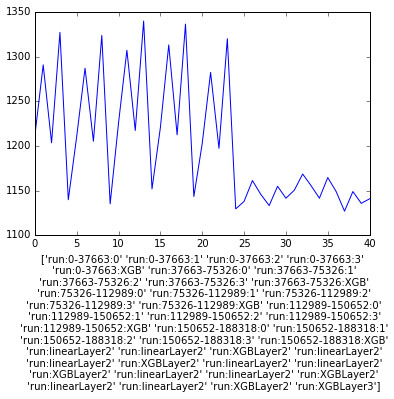

In [32]:

MAE_tracking_graph=np.array(MAE_tracking)

print(MAE_tracking_graph.T)

plt.plot(MAE_tracking_graph.T[1])
plt.xlabel(MAE_tracking_graph.T[0])

plt.show()

del MAE_tracking_graph

### Predict layer 1 on test 

In [33]:
x_layer2_test = []
start_time1 = time.time()
for i in range(len(regrList)): # for each of the regressions we use, fit/predict the data
    start_time = time.time()            
    estimator=skclone(regrList[i], safe=True)
    print(estimator)
    estimator.fit(x,y) # use the estimator from the training, but refit to the whole data set!
    curr_predict=estimator.predict(x_test_data)
    print("predict time:{}s".format(round((time.time()-start_time), 3) ))
    
    if x_layer2_test == []:
        x_layer2_test = np.array(curr_predict.copy())
    else:
        x_layer2_test = np.column_stack((x_layer2_test,curr_predict))

#XGB -- it doesn't fit the pattern of scikit, so do it seperatly
if use_xgb == True:

    dtrain = xgb.DMatrix(x, label=y)
    dtest = xgb.DMatrix(x_test_data)
    gbdt=xgb.train(xgb_params, dtrain, best_nrounds)

    # now do a prediction and spit out a score(MAE) that means something
    #start_time = time.time()
    curr_predict=gbdt.predict(dtest)
    x_layer2_test = np.column_stack((x_layer2_test,curr_predict))
    #print("Mean abs error: {:.2f}".format(np.mean(abs(cache[i+1] - y_test))))
    print("XGB predict time:{}s".format(round((time.time()-start_time), 3) ))

# add an avged column of all the runs
avg_column=np.mean(x_layer2_test, axis=1)
x_layer2_test=np.column_stack((x_layer2_test,avg_column))
print("AVG column added - length of new row: {}".format(len(x_layer2[0])))

print("Fold run time:{}s".format(round((time.time()-start_time1), 3) ))   

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=500, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
predict time:123.939s
Ridge(alpha=40, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
predict time:5.101s
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


predict time:107.9s
KNeighborsRegressor(algorithm='auto', leaf_size=3, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=15, p=2,
          weights='uniform')
predict time:1661.727s
XGB predict time:1830.924s
AVG column added - length of new row: 7
Fold run time:2067.88s


In [34]:
start_time = time.time()
# use the new clusters number to predict each locations cluster
print "\nredo kmeans with new cluster number from meanshift +1 to account for sampling..."
k_means =KMeans(n_clusters=80,n_jobs=12)
final_clusters=k_means.fit_predict(x_layer2_test)
print("kmeans round 2 time:{}s".format(round((time.time()-start_time), 3) ))
display("Clusters sample:",final_clusters[:15])

display("test-first 3",x_layer2_test[:3])
print("length of row: {}".format(len(x_layer2_test[0])))

x_layer2_test=np.column_stack((x_layer2_test,final_clusters))

display("test-first 3",x_layer2_test[:3])
print("length of row: {}".format(len(x_layer2_test[0])))
print("run time:{}s".format(round((time.time()-start_time), 3) ))   


redo kmeans with new cluster number from meanshift +1 to account for sampling...
kmeans round 2 time:51.169s


'Clusters sample:'

array([74, 46, 52, 62,  7, 13, 72, 68,  3, 51, 51, 35, 35, 13, 18], dtype=int32)

'test-first 3'

array([[ 7.45185611,  7.22354344,  7.53799811,  7.4210465 ,  7.34254217,
         7.39539727],
       [ 7.70357059,  7.47171944,  7.57829824,  7.65526132,  7.56067944,
         7.59390581],
       [ 9.01941589,  9.43550501,  8.93359826,  8.94614793,  9.05255508,
         9.07744443]])

length of row: 6


'test-first 3'

array([[  7.45185611,   7.22354344,   7.53799811,   7.4210465 ,
          7.34254217,   7.39539727,  74.        ],
       [  7.70357059,   7.47171944,   7.57829824,   7.65526132,
          7.56067944,   7.59390581,  46.        ],
       [  9.01941589,   9.43550501,   8.93359826,   8.94614793,
          9.05255508,   9.07744443,  52.        ]])

length of row: 7
run time:51.185s


### Layer 2 predictions!

In [35]:
#Linear
start_time = time.time()
layer3_predict_linear=layer2_Lin_regr.predict(x_layer2_test)
print("Linear predict time:{}s".format(round((time.time()-start_time), 3) ))    
x_layer3_test = layer3_predict_linear

#KNeighborsRegressor
start_time = time.time()
layer3_predict_KNeighbors=layer2_KNN_regr.predict(x_layer2_test)
print("KNeighbors predict time:{}s".format(round((time.time()-start_time), 3) ))    
x_layer3_test = np.column_stack((x_layer3_test,layer3_predict_KNeighbors))  


# The XGB version of layer 2
dtest = xgb.DMatrix(x_layer2_test)
start_time = time.time()
layer3_gbdt_predict=layer2_gbdt.predict(dtest)
print("XGB predict time:{}s".format(round((time.time()-start_time), 3) ))    
x_layer3_test = np.column_stack((x_layer3_test,layer3_gbdt_predict))  


# ? average those weighted to XGB
start_time = time.time()

layer3_avg_predict=(layer3_predict_linear+layer3_predict_KNeighbors+layer3_gbdt_predict+layer3_gbdt_predict)/4
print("AVG predict time:{}s".format(round((time.time()-start_time), 3) ))    

x_layer3_test = np.column_stack((x_layer3_test,layer3_avg_predict))  



Linear predict time:0.003s
KNeighbors predict time:5.529s
XGB predict time:3.995s
AVG predict time:0.003s


In [38]:
#spit out that good scoring linear result...
test_data['loss']=np.exp(layer3_predict_linear)


result=test_data[['id','loss',]]
output_fname="result_submission_stack_linear.csv"
display(writeData(result,output_fname))

['id,loss\n',
 '4,1546.57802764\n',
 '6,1975.85611938\n',
 '9,8550.07748241\n',
 '12,6168.29801318\n']

### Predict Layer 3

In [36]:
#the XGB version:
dtest = xgb.DMatrix(x_layer3_test)
test_data['loss']=np.exp(layer3_gbdt.predict(dtest))

result=test_data[['id','loss',]]
output_fname="result_submission_stack_xgb.csv"
display(writeData(result,output_fname))



['id,loss\n',
 '4,1715.84985352\n',
 '6,1993.97631836\n',
 '9,6332.97119141\n',
 '12,6663.73095703\n']

In [37]:
#let's have a look at the std of the result, as a cross check
print("result std:",result.std(axis=0))

('result std:', id      170098.328125
loss      1730.584595
dtype: float32)


# EOF 